## 過学習のリスクを評価するためのコード
クロスバリデーションを用いた過学習の評価

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
import joblib

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/scaled_data.csv'
df = pd.read_csv(data_path)

# 特徴量の選択
important_features = [
    'OverallQual_Capped', 'OverallHomeQuality', 'FunctionalSpace',
    'GarageQuality', 'capped_log_GrLivArea', 'TotalBath_Capped',
    'OverallCond', 'GarageCars_Capped', 'BsmtExposureQual', 'YearBuilt_Capped',
    'BasementQualityInteraction', 'log_TotalBsmtSF_Capped',
    'HouseAge', 'OutdoorSpaceQuality', 'PorchAndDeckArea', 'LotArea'
]

# データセットの作成
X = df[important_features]
y = df['SalePrice']

# モデルのロード
xgb_model_path = '/Users/hayakawakazue/Downloads/house_price/model/xgboost_0721_1.joblib'
gbr_model_path = '/Users/hayakawakazue/Downloads/house_price/model/gradient_boosting_0721_1.joblib'
rf_model_path = '/Users/hayakawakazue/Downloads/house_price/model/random_forest_0721_1.joblib'
catboost_model_path = '/Users/hayakawakazue/Downloads/house_price/model/catboost_model_0721_1.joblib'

xgb_best = joblib.load(xgb_model_path)
gbr_best = joblib.load(gbr_model_path)
rf_best = joblib.load(rf_model_path)
catboost_best = joblib.load(catboost_model_path)

# アンサンブルモデルの定義
ensemble_model = VotingRegressor(estimators=[
    ('gbr', gbr_best), ('xgb', xgb_best), ('rf', rf_best), ('catboost', catboost_best)
])

# クロスバリデーションの設定
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error)

# クロスバリデーションの実行
cv_results = cross_val_score(ensemble_model, X, y, cv=kf, scoring=mae_scorer)

# 結果の表示
print(f"Cross-Validation MAE scores: {cv_results}")
print(f"Mean CV MAE: {np.mean(cv_results):.4f}")
print(f"Std CV MAE: {np.std(cv_results):.4f}")


Cross-Validation MAE scores: [15477.9894275  15244.03564692 18720.58436609 17279.68612666
 13695.09996353]
Mean CV MAE: 16083.4791
Std CV MAE: 1741.3141


学習曲線を用いた過学習の評価

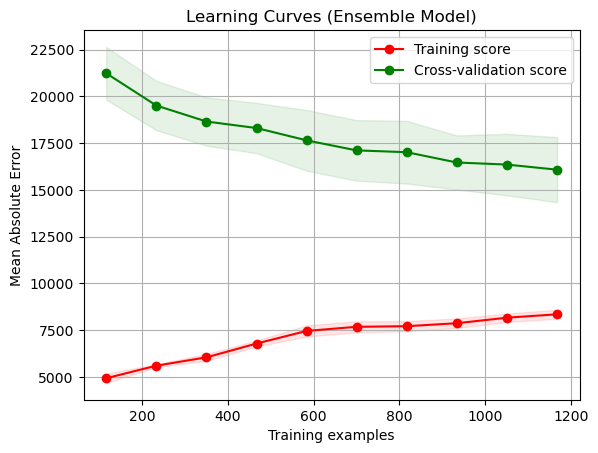

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# 学習曲線のプロット
train_sizes, train_scores, test_scores = learning_curve(ensemble_model, X, y, cv=kf, scoring=mae_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

# スコアの平均と標準偏差の計算
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 学習曲線のプロット
plt.figure()
plt.title("Learning Curves (Ensemble Model)")
plt.xlabel("Training examples")
plt.ylabel("Mean Absolute Error")

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()
